In [6]:
import pandas as pd

df = pd.read_excel("preprocessed.xlsx")
columns_ignore = ["name", "released", "score", "votes", "gross", "same_year"]

In [7]:
df.memory_usage(index=True, deep=True).sum() / 1024**2

3.204771041870117

In [8]:
higher_order_terms = [
    "budget",
    "log_budget",
    "log_gross",
    "log_runtime",
    "name_len",
    "robust_budget",
    "robust_gross",
    "runtime",
    "year",
    "year_relative",
    "has_number"
]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_poly = poly.fit_transform(df[higher_order_terms])
X = df.drop(
    columns_ignore + higher_order_terms,
    axis=1,
)
X = pd.concat([X, pd.DataFrame(X_poly)], axis=1).to_numpy()
y = df["score"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
X.shape[1]

250

In [11]:
import sys

sys.getsizeof(X) / 1024**2

0.0001220703125

# Models

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


def plot_predictions(y_test, y_pred):
    plt.scatter(y_test, y_pred, color="blue")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Predictions vs. Truth")
    plt.show()


def evaluate(model, X, y):
    pred = model.predict(X)
    print("Mean squared error: %.2f" % mean_squared_error(y, pred))
    print("Coefficient of determination: %.2f" % r2_score(y, pred))
    plot_predictions(y, pred)

## LinearRegression

In [13]:
from sklearn.linear_model import LinearRegression


linear_regressor = LinearRegression()
linear_regressor = linear_regressor.fit(X_train, y_train)

Mean squared error: 0.56
Coefficient of determination: 0.40


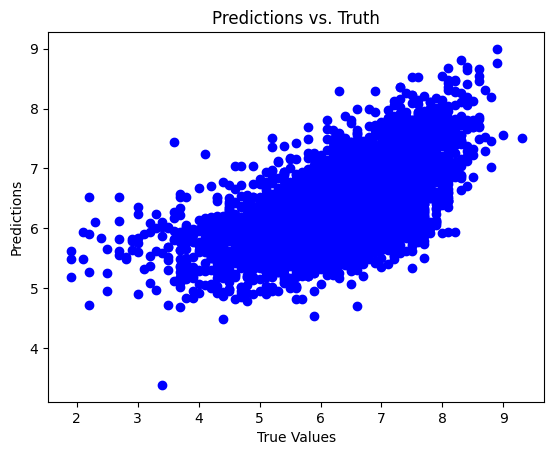

Mean squared error: 0.57
Coefficient of determination: 0.38


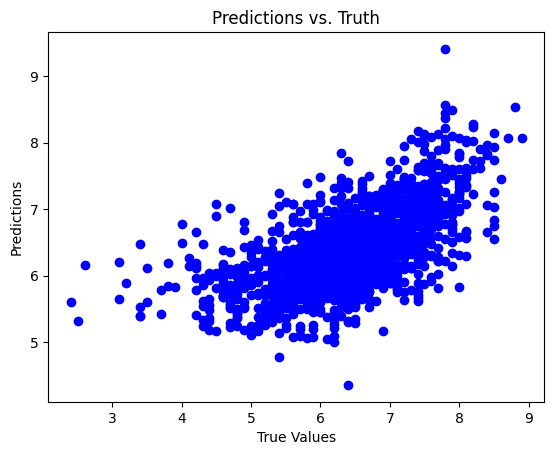

In [14]:
evaluate(linear_regressor, X_train, y_train)
evaluate(linear_regressor, X_test, y_test)

## DecisionTree

In [15]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=6)
decision_tree = decision_tree.fit(X_train, y_train)

Mean squared error: 0.62
Coefficient of determination: 0.34


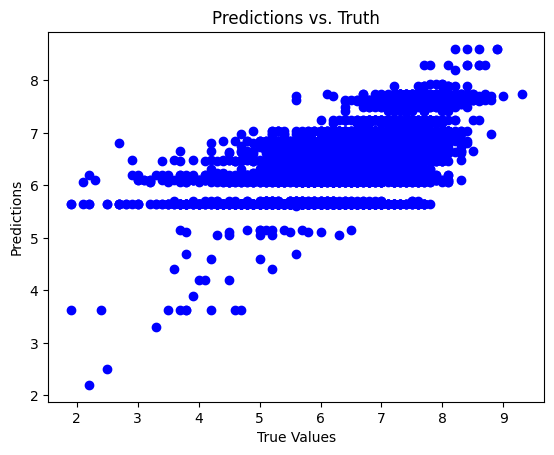

Mean squared error: 0.71
Coefficient of determination: 0.22


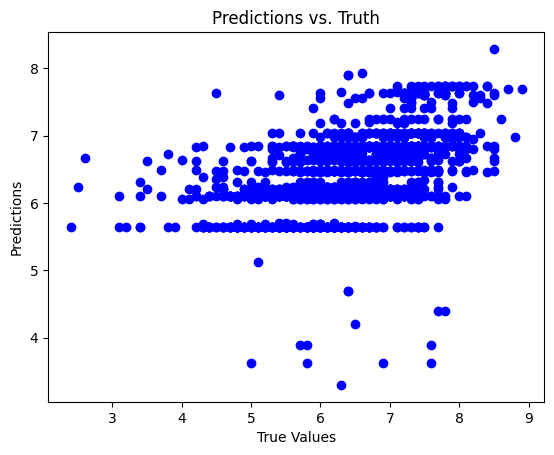

In [16]:
evaluate(decision_tree, X_train, y_train)
evaluate(decision_tree, X_test, y_test)

## Forest Regressor

In [17]:
# forest
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)

Mean squared error: 0.09
Coefficient of determination: 0.91


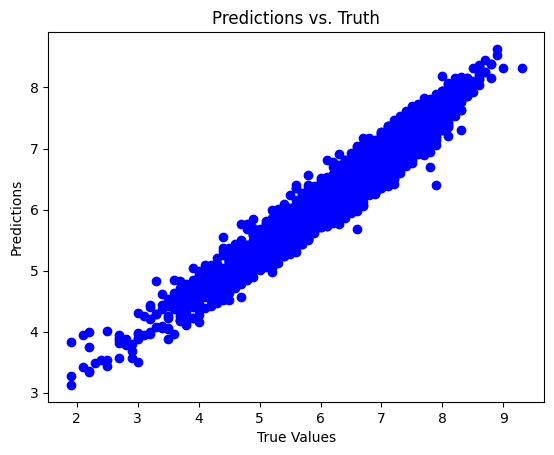

Mean squared error: 0.56
Coefficient of determination: 0.38


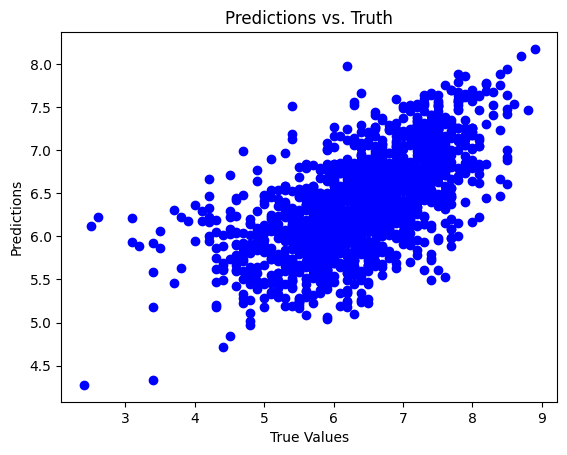

In [18]:
evaluate(forest, X_train, y_train)
evaluate(forest, X_test, y_test)

## Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor()
gradient_boosting = gradient_boosting.fit(X_train, y_train)

Mean squared error: 0.52
Coefficient of determination: 0.44


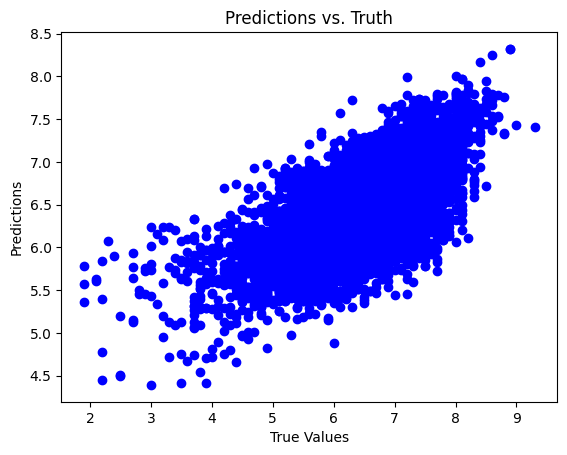

Mean squared error: 0.56
Coefficient of determination: 0.38


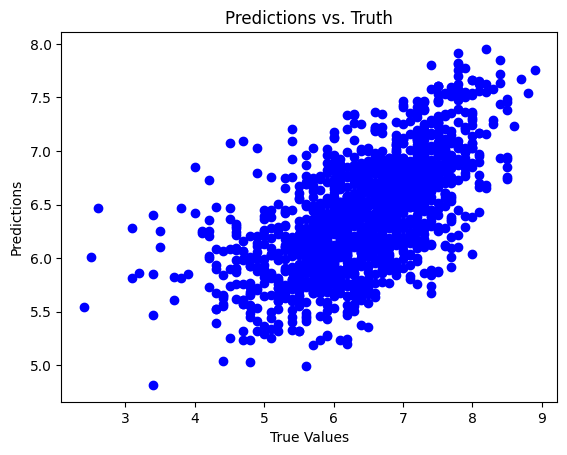

In [20]:
evaluate(gradient_boosting, X_train, y_train)
evaluate(gradient_boosting, X_test, y_test)

In [21]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=64,
    activation="logistic",
    solver="sgd",
    alpha=0,
    batch_size=1,
    learning_rate_init=0.01,
    shuffle=True,
    momentum=0,
    n_iter_no_change=50,
    max_iter=1000,
)
mlp = mlp.fit(X_train, y_train)

Mean squared error: 0.83
Coefficient of determination: 0.10


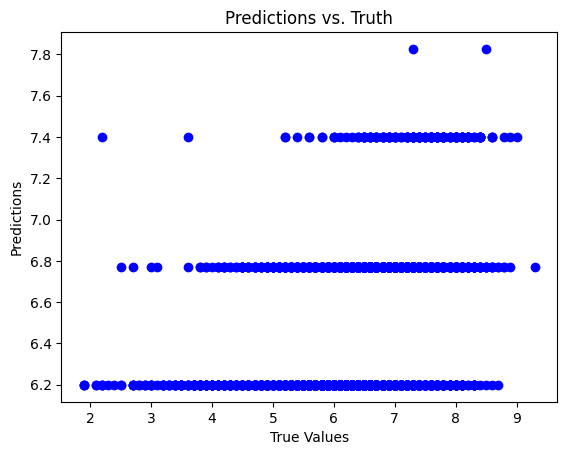

Mean squared error: 0.80
Coefficient of determination: 0.12


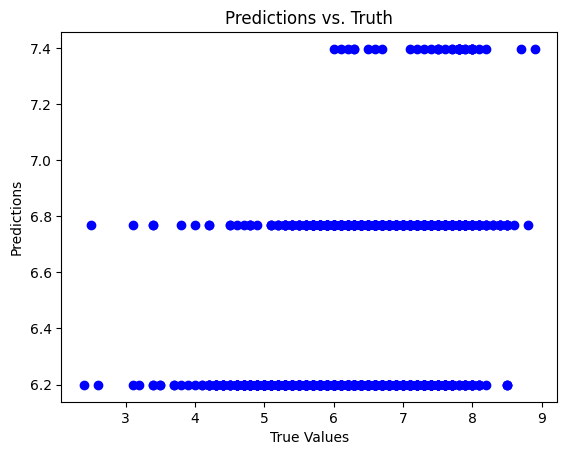

In [22]:
evaluate(mlp, X_train, y_train)
evaluate(mlp, X_test, y_test)

## KNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)
knn = knn.fit(X_train, y_train)

Mean squared error: 0.70
Coefficient of determination: 0.25


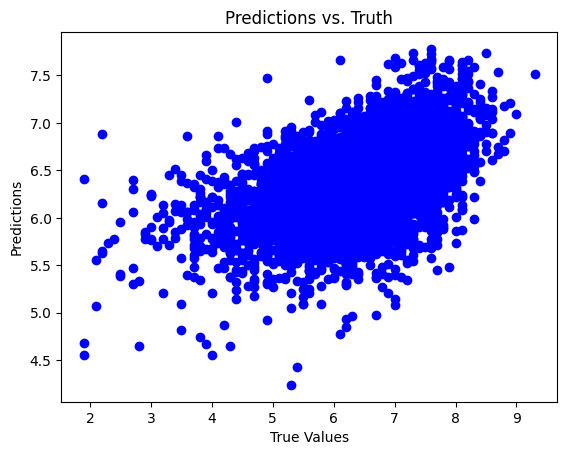

Mean squared error: 0.76
Coefficient of determination: 0.16


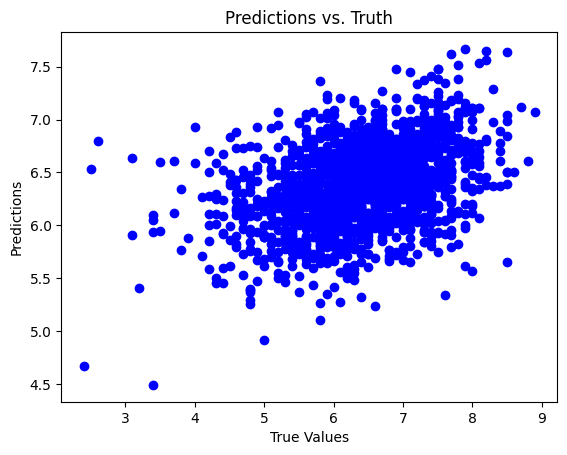

In [24]:
evaluate(knn, X_train, y_train)
evaluate(knn, X_test, y_test)

## Clustering

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans = kmeans.fit(X_train)

/Users/kalebsmith/ownCloud/school/cs-201r/final-project/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Mean squared error: 38.22
Coefficient of determination: -40.02


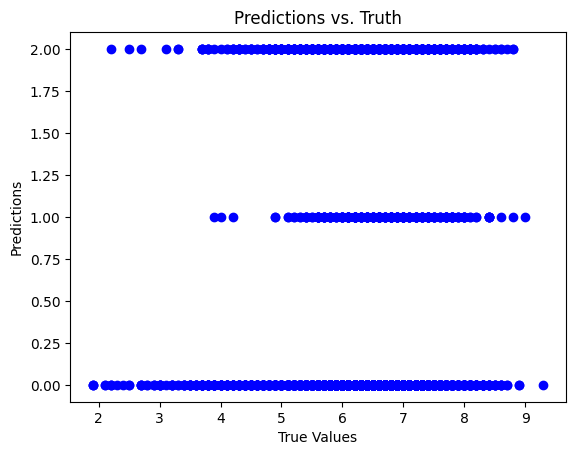

Mean squared error: 38.49
Coefficient of determination: -41.35


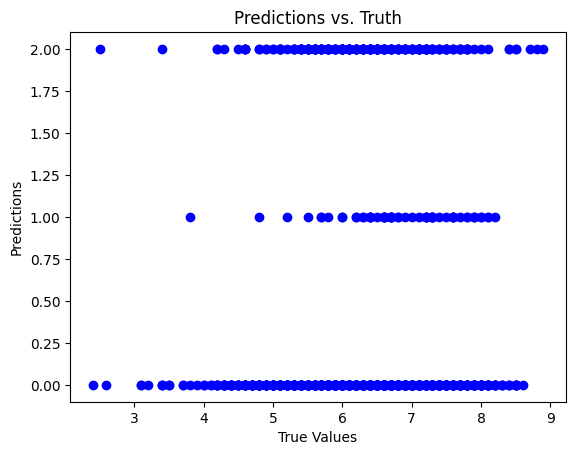

In [26]:
evaluate(kmeans, X_train, y_train)
evaluate(kmeans, X_test, y_test)

In [27]:
# Ensemble
from sklearn.ensemble import VotingRegressor

reg1 = knn
reg2 = forest
reg3 = gradient_boosting
reg4 = linear_regressor
reg5 = decision_tree
reg6 = mlp


def weight(model):
    return 1 / mean_squared_error(model.predict(X_test), y_test)


ereg = VotingRegressor(
    estimators=[("knn", reg1), ("rf", reg2), ("gb", reg3), ("lr", reg4)],
    weights=[weight(reg1), weight(reg2), weight(reg3), weight(reg4)],
)
ereg = ereg.fit(X_train, y_train)

Mean squared error: 0.37
Coefficient of determination: 0.60


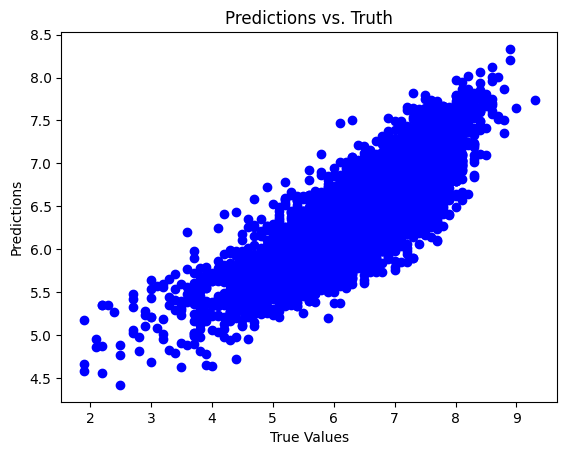

Mean squared error: 0.55
Coefficient of determination: 0.39


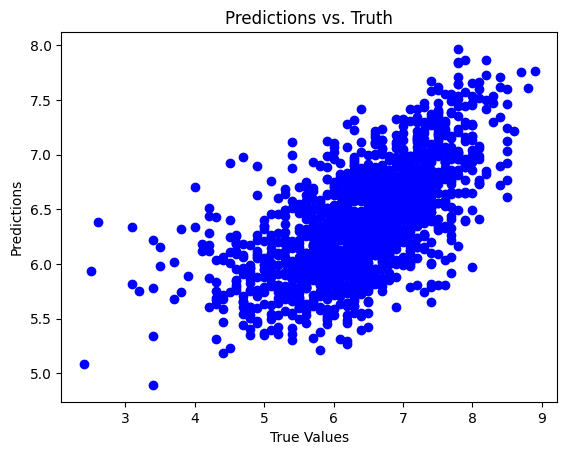

In [28]:
evaluate(ereg, X_train, y_train)
evaluate(ereg, X_test, y_test)

In [29]:
# Ensemble
from sklearn.ensemble import StackingRegressor

reg1 = knn
reg2 = forest
reg3 = gradient_boosting
reg4 = linear_regressor
reg5 = decision_tree
reg6 = mlp

stack = StackingRegressor(
    estimators=[("knn", reg1), ("rf", reg2), ("gb", reg3), ("lr", reg4)],
    final_estimator=MLPRegressor(
        hidden_layer_sizes=64,
        activation="logistic",
        solver="sgd",
        alpha=0,
        batch_size=1,
        learning_rate_init=0.01,
        shuffle=True,
        momentum=0,
        n_iter_no_change=50,
        max_iter=1000,
    ),
)
stack = stack.fit(X_train, y_train)

Mean squared error: 0.45
Coefficient of determination: 0.52


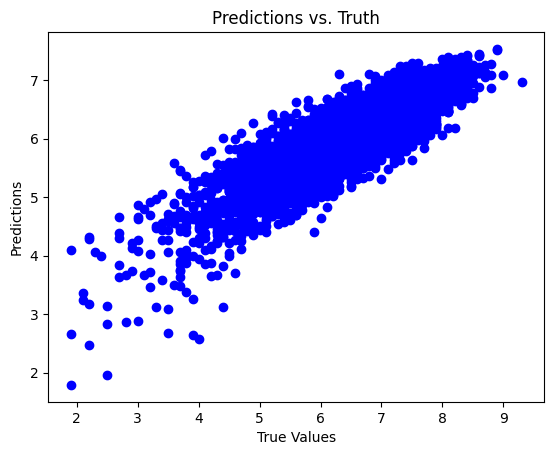

Mean squared error: 0.69
Coefficient of determination: 0.25


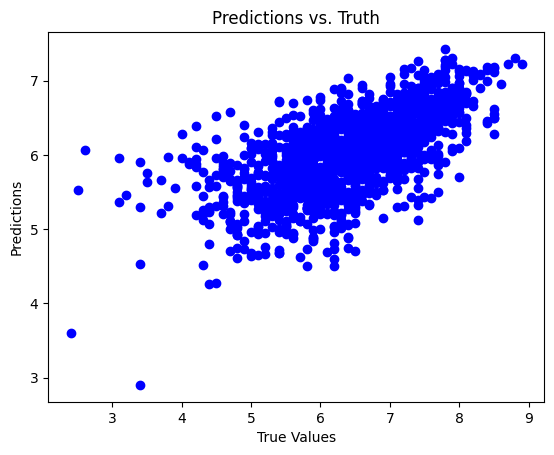

In [30]:
evaluate(stack, X_train, y_train)
evaluate(stack, X_test, y_test)